# Analytic Methods

This book has focused on computational methods like simulation and resampling, but some of the problems we solved have analytic solutions that can be much faster.

This chapter presents some of these methods and explains how they work.
At the end of the chapter, I make suggestions for integrating computational and analytic methods for data analysis.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap14.ipynb).

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Normal Probability Plots

Many analytic methods are based on the properties of the normal distribution, for two reasons: distributions of many measurements in the real world are well-approximated by normal distributions, and normal distributions have mathematical properties that make them useful for analysis.

To demonstrate the first point, we'll look at some of the measurements in the penguin dataset, which we saw in Section XXX.
Then we'll explore the mathematical properties of the normal distribution.
Instructions for downloading the penguin dataset are in the notebook for this chapter.


The following cell downloads the data.

In [5]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

<IPython.core.display.Javascript object>

We can read the data like this.

In [6]:
penguins = pd.read_csv("penguins_raw.csv")
penguins.shape

(344, 17)

<IPython.core.display.Javascript object>

The datasets contain measurements from three penguin species.
For this example, we'll select the Adelie penguins.

In [7]:
adelie = penguins.query('Species.str.startswith("Adelie")').copy()
len(adelie)

152

<IPython.core.display.Javascript object>

To see if the penguin weights follow a normal distribution, we'll compute the empirical CDF of the data.

In [8]:
from empiricaldist import Cdf

weights = adelie["Body Mass (g)"].dropna()
cdf_weights = Cdf.from_seq(weights)

<IPython.core.display.Javascript object>

And we'll compute the analytic CDF of a normal distribution with the same mean and standard deviation.

In [9]:
m, s = weights.mean(), weights.std()
m, s

(3700.662251655629, 458.5661259101348)

<IPython.core.display.Javascript object>

In [10]:
from scipy.stats import norm

dist = norm(m, s)
qs = np.linspace(m - 3.5 * s, m + 3.5 * s)
ps = dist.cdf(qs)

<IPython.core.display.Javascript object>

Here's what the CDF of the data looks like compared to the normal model.

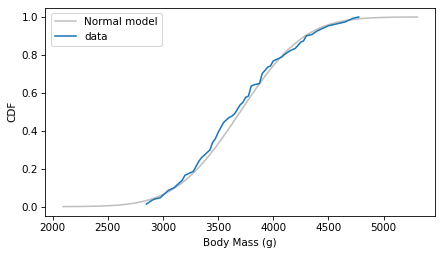

<IPython.core.display.Javascript object>

In [11]:
plt.plot(qs, ps, color="gray", alpha=0.5, label="Normal model")
cdf_weights.plot(label="data")

decorate(ylabel="CDF")

The normal distribution might be a good enough model of this data, but it's certainly not a perfect fit.

In general, plotting the CDF of the data and the CDF of a model is a good way to evaluate how well the model fits the data.
But one drawback of this method is that it depends on how well we estimate the parameters of the model -- in this example the mean and standard deviation.

An alternative is a normal probability plot, which does not depend on our ability to estimate parameters.
A normal probability plot is a kind of "P-P plot", which stands for **percentile-percentile plot**, because it plots the percentiles of the data against the percentiles of a model.
In a normal probability plot, the model is a standard normal distribution -- that is, one with mean 0 and standard deviation 1.

In a normal probability plot the $y$ values are the sorted measurements.

In [12]:
ys = np.sort(weights)

<IPython.core.display.Javascript object>

And the $x$ values are the corresponding percentiles of a normal distribution, computes using the `ppf` method of the `norm` object, which computes the inverse CDF.

In [13]:
n = len(weights)
xs = norm.ppf((np.arange(n) + 0.5) / n)

<IPython.core.display.Javascript object>

If the measurements are actually drawn from a normal distribution, the $y$ and $x$ values should fall on a straight line.
To see how well they do, we can use `linregress` to fit a line.

In [14]:
from scipy.stats import linregress

results = linregress(xs, ys)
intercept, slope = results.intercept, results.slope

fit_xs = np.linspace(-3, 3)
fit_ys = intercept + slope * fit_xs

<IPython.core.display.Javascript object>

Here are the results along with the fitted line.

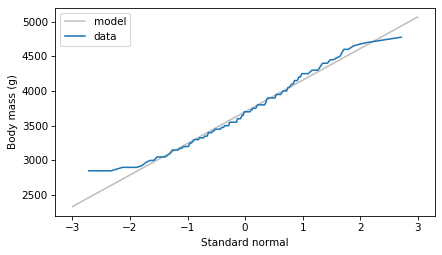

<IPython.core.display.Javascript object>

In [15]:
plt.plot(fit_xs, fit_ys, color="gray", alpha=0.5, label="model")
plt.plot(xs, ys, label="data")

decorate(xlabel="Standard normal", ylabel="Body mass (g)")

The normal probability plot is not a perfectly straight line, which indicates that the normal distribution is not a perfect model for this data.
One reason is that the dataset includes male and female penguins, so let's see what happens if we plot the two groups separately.
The following function encapsulates the steps we used to make a normal probability plot.


In [16]:
def normal_probability_plot(sample, **options):
    """Makes a normal probability plot with a fitted line."""
    n = len(sample)
    xs = norm.ppf((np.arange(n) + 0.5) / n)
    ys = np.sort(sample)

    results = linregress(xs, ys)
    intercept, slope = results.intercept, results.slope

    fit_xs = np.linspace(-3, 3)
    fit_ys = intercept + slope * fit_xs

    plt.plot(fit_xs, fit_ys, color="gray", alpha=0.5)
    plt.plot(xs, ys, **options)
    decorate(xlabel="Standard normal")

<IPython.core.display.Javascript object>

Here's what the results look like for male and female penguins separately.

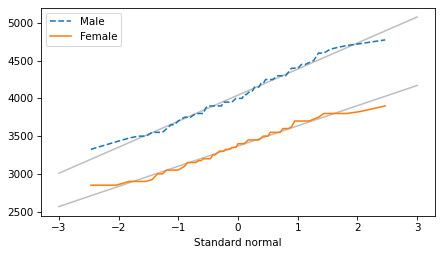

<IPython.core.display.Javascript object>

In [17]:
grouped = adelie.groupby("Sex")

weights_male = grouped.get_group("MALE")["Body Mass (g)"]
normal_probability_plot(weights_male, ls="--", label="Male")

weights_female = grouped.get_group("FEMALE")["Body Mass (g)"]
normal_probability_plot(weights_female, label="Female")

The normal probability plots for both groups are close to a straight line, which indicates that the distributions of weight follow normal distributions.
When we put the groups together, the distribution of their weights is a mixture of two normal distributions with different means -- and a mixture like that is not always well modeled by a normal distribution.

Now let's consider some of the mathematical properties of a normal distribution that make them so useful for analysis.

## Normal Distributions

The following class defines an object that represents a normal distribution.
It contains as attributes the parameters `mu` and `sigma2`, which represent the mean and variance of the distribution.

In [18]:
class Normal:
    """Represents a Normal distribution"""

    def __init__(self, mu, sigma2):
        """Make a Normal object.

        mu: mean
        sigma2: variance
        """
        self.mu = mu
        self.sigma2 = sigma2

    def __repr__(self):
        """Returns a string representation."""
        return f"Normal({self.mu}, {self.sigma2})"

    __str__ = __repr__

<IPython.core.display.Javascript object>

As an example, we'll create a `Normal` object that represents a normal distribution with the same mean and variance as the weights of the male penguins.

In [19]:
m, s = weights_male.mean(), weights_male.std()
dist_male = Normal(m, s**2)
dist_male

Normal(4043.4931506849316, 120278.25342465754)

<IPython.core.display.Javascript object>

And another `Normal` object with the same mean and variance as the weights of the female penguins.

In [20]:
m, s = weights_female.mean(), weights_female.std()
dist_female = Normal(m, s**2)
dist_female

Normal(3368.8356164383563, 72565.63926940637)

<IPython.core.display.Javascript object>

To add methods to this class, we'll use a Jupyter magic command, `add_method_to`.
This command is not part of Python -- it only works in Jupyter notebooks.

The following method generates a random sample from a normal distribution.

In [21]:
%%add_method_to Normal

def sample(self, n):
    """Generate a random sample from this distribution."""
    sigma = np.sqrt(self.sigma2)
    return np.random.normal(self.mu, sigma, n)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We'll use `sample` to demonstrate the first useful property of a normal distribution: if you draw values from two normal distributions and add them, the distribution of the sum is also normal.

As an example, we'll generate samples from the `Normal` objects we just made, add them together, and make a normal probability plot of the sums.

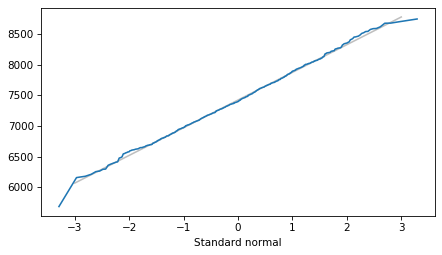

<IPython.core.display.Javascript object>

In [22]:
sample_sum = dist_male.sample(1000) + dist_female.sample(1000)
normal_probability_plot(sample_sum)

The normal probability plot looks like a straight line, which indicates that the sums follow a normal distribution.

And that's not all -- if we know the parameters of the two distributions, we can compute the parameters of the distribution of the sum.
The following method shows how.

In [23]:
%%add_method_to Normal


def __add__(self, other):
    """Distribution of the sum of two normal distribution."""
    return Normal(self.mu + other.mu, self.sigma2 + other.sigma2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the distribution of the sum, the mean is the sum of the means and the variance is the sum of the variances.
Now that we've defined the special method `__add__`, we can use the `+` operator to "add" two distributions -- that is, to compute the distribution of their sum.

In [24]:
dist_sum = dist_male + dist_female
dist_sum

Normal(7412.328767123288, 192843.8926940639)

<IPython.core.display.Javascript object>

To confirm that this result is correct, we'll use the following method, which plots the analytic CDF of a normal distribution.

In [151]:
%%add_method_to Normal


def plot_cdf(self, n_sigmas=3.5, **options):
    """Plot the CDF of this distribution."""
    mu, sigma = self.mu, np.sqrt(self.sigma2)
    low, high = mu - n_sigmas * sigma, mu + n_sigmas * sigma
    xs = np.linspace(low, high, 101)
    ys = norm.cdf(xs, mu, sigma)
    plt.plot(xs, ys, **options)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here's the result along with the empirical CDF of the random sample of sums.

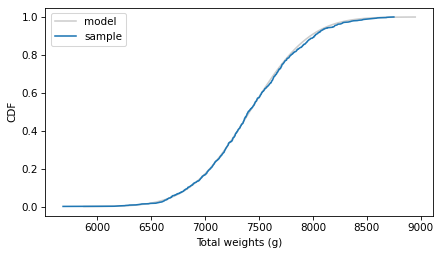

<IPython.core.display.Javascript object>

In [152]:
dist_sum.plot_cdf(color="gray", alpha=0.4, label="model")
Cdf.from_seq(sample_sum).plot(label="sample")

decorate(xlabel="Total weights (g)", ylabel="CDF")

It looks like the parameters we computed are correct, which confirms that we can add two normal distributions by adding their means and variances.

As a corollary, if we generate `n` values from a normal distribution and add them up, the distribution of the sum is also a normal distribution.
To demonstrate, we'll start by generating 73 values from the distribution of male weights and adding them up.
The following loop does that 1001 times, so the result is a sample from the distribution of sums.

In [153]:
n = len(weights_male)
sample_sums_male = [dist_male.sample(n).sum() for i in range(1001)]
n

73

<IPython.core.display.Javascript object>

The following method makes a `Normal` object that represents the distribution of the sums.
To compute the parameters, we multiply both the mean and variance by `n`.

In [154]:
%%add_method_to Normal


def sum(self, n):
    """Return the distribution of the sum of n values."""
    return Normal(n * self.mu, n * self.sigma2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here's the distribution of the sum of the weights.

In [155]:
dist_sums_male = dist_male.sum(n)

<IPython.core.display.Javascript object>

And here's how it compares to the empirical distribution of the random sample.

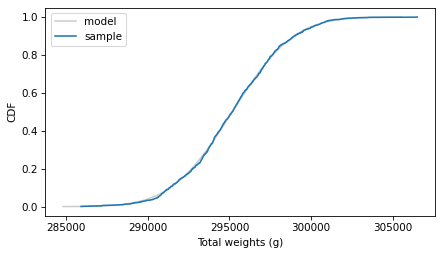

<IPython.core.display.Javascript object>

In [156]:
model_options = dict(color="gray", alpha=0.4, label="model")

dist_sums_male.plot_cdf(**model_options)
Cdf.from_seq(sample_sums_male).plot(label="sample")

decorate(xlabel="Total weights (g)", ylabel="CDF")

The analytic distribution fits the distribution of the sample, which confirms that the `sum` method is correct.
So if we collect a sample of `n` measurements, we can compute the distribution of their sum.

Then, to compute the distribution of their mean, we can use a third property of a normal distribution: if we multiply or divide by a constant, the result is a normal distribution.
The following methods shows how we compute the parameters of the distribution of the product or quotient.

In [157]:
%%add_method_to Normal


def __mul__(self, factor):
    """Multiplies by a scalar."""
    return Normal(factor * self.mu, factor**2 * self.sigma2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [158]:
%%add_method_to Normal


def __truediv__(self, factor):
    """Divides by a scalar."""
    return self * (1/factor)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To compute the distribution of the product we multiply the mean by `factor` and the variance by the square of `factor`.
We can use this property to compute the distribution of the sample means.

In [159]:
dist_mean_male = dist_sums_male / n

<IPython.core.display.Javascript object>

To see if the result is correct, we'll also compute the means of the random samples.

In [160]:
sample_means_male = np.array(sample_sums_male) / n

<IPython.core.display.Javascript object>

And compare the normal model to the empirical CDF of the sample means.

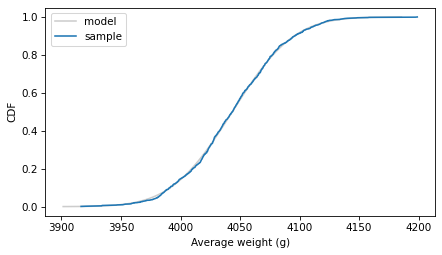

<IPython.core.display.Javascript object>

In [161]:
dist_mean_male.plot_cdf(**model_options)
Cdf.from_seq(sample_means_male).plot(label="sample")

decorate(xlabel="Average weight (g)", ylabel="CDF")

The model and the simulation results agree, which shows that we can compute the distribution of the sample means analytically -- which is very fast, compared to resampling.

Now that we know the sampling distribution of the mean, we can use it to compute the standard error, which is the standard deviation of the sampling distribution.

In [162]:
standard_error = np.sqrt(dist_mean_male.sigma2)
standard_error

40.591222045992765

<IPython.core.display.Javascript object>

This result suggests a shortcut we can use to compute the standard error directly, without computing the sampling distribution.
In the sequence of steps we followed, we multiplied the variance by `n` and then divided by `n**2` -- the net effect was to divide the variance by `n`, which is the same as dividing the standard deviation by the square root of `n`.

So we can compute the standard error of the sample mean like this.

In [163]:
standard_error = weights_male.std() / np.sqrt(n)
standard_error

40.59122204599277

<IPython.core.display.Javascript object>

This calculation is exact if the original distribution is normal, and approximate if the original distribution is approximately normal.
We'll see why soon, but first let's consider one more result we can compute with normal distributions, the distribution of differences.

## Distribution of Differences

Putting together the steps from the previous section, here's how we can compute the distribution of sample means for the weights of the female penguins.

In [164]:
n = len(weights_female)
dist_mean_female = dist_female.sum(n) / n
dist_mean_female

Normal(3368.835616438356, 994.0498530055667)

<IPython.core.display.Javascript object>

Now we have sampling distributions for the average weight of male and female penguins -- let's compute the distribution of the differences.
The following method computes the distribution of the difference between values from two normal distributions.

In [165]:
%%add_method_to Normal

def __sub__(self, other):
    """Compute the distribution of a difference."""
    return Normal(self.mu - other.mu, self.sigma2 + other.sigma2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As you might expect, the mean of the differences is the difference of the means.
But as you might not expect, the variance of the differences is not the difference of the variances -- it's the sum!
To see why, imagine we perform subtraction in two steps:

* If we negate the second distribution, the mean is negated but the variance is the same.

* Then if we add in the first distribution, the variance of the sum is the sum of the variances.

If that doesn't convince you, let's test it.
Here's the analytic distribution of the differences.

In [166]:
dist_diff_means = dist_mean_male - dist_mean_female
dist_diff_means

Normal(674.6575342465753, 2641.697160192656)

<IPython.core.display.Javascript object>

And here's a random sample of differences.

In [167]:
sample_sums_female = [dist_female.sample(n).sum() for i in range(1001)]
sample_means_female = np.array(sample_sums_female) / n
sample_diff_means = sample_means_male - sample_means_female

<IPython.core.display.Javascript object>

The following figure shows the empirical CDF of the random sample and the analytic CDF of the normal distribution.

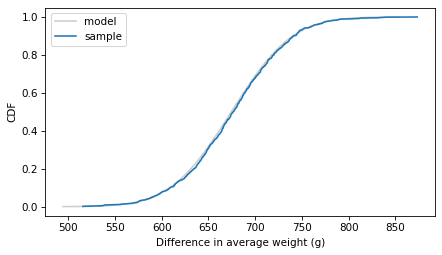

<IPython.core.display.Javascript object>

In [168]:
dist_diff_means.plot_cdf(**model_options)
Cdf.from_seq(sample_diff_means).plot(label="sample")

decorate(xlabel="Difference in average weight (g)", ylabel="CDF")

They agree, which confirms that we found the distribution of the differences correctly. 
We can use this distribution to compute a confidence interval for the difference in weights.
We'll use the following method to compute the "percent point function", which is the inverse CDF.

In [169]:
%%add_method_to Normal

def ppf(self, xs):
    sigma = np.sqrt(self.sigma2)
    return norm.ppf(xs, self.mu, sigma)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The 5th and 95th percentiles form a 90% confidence interval.

In [170]:
ci90 = dist_diff_means.ppf([0.05, 0.95])
ci90

array([590.1162635 , 759.19880499])

<IPython.core.display.Javascript object>

We get approximately the same results from the random sample.

In [171]:
np.percentile(sample_diff_means, [5, 95])

array([590.3342552 , 760.38353663])

<IPython.core.display.Javascript object>

The analytic method is faster than resampling, and it is deterministic -- that is, not random.

However, everything we've done so far is based on the assumption that the distribution of measurements is normal.
That's not always true -- in fact, with real data it is never exactly true.
But even if the distribution of the measurements isn't normal, if we add up many measurements, the distribution of their sum is often close to normal.
That is the power of the Central Limit Theorem.

## Central Limit Theorem

As we saw in the previous sections, if we add values drawn from normal distributions, the distribution of the sum is normal.
Most other distributions don't have this property -- for example, if we add values drawn from an exponential distribution, the distribution of the sum is not exponential.

But if we add up `n` values from almost any distribution, the distribution of the sum converges to normal as `n` increases.
More specifically, if the distribution of the values has mean `m` and variance `s2` the distribution of the sum converges to a normal distribution with mean `n * m` and variance `n * s2`.

That conclusion is the Central Limit Theorem (CLT).
It is one of the most useful tools for statistical analysis, but it comes with caveats:

-   The values have to come from the same distribution (although this requirement can be relaxed).

-   The values have to be drawn independently. If they are correlated, the CLT doesn't apply.

-   The values have to be drawn from a distribution with finite mean and variance. So the CLT doesn't apply to some long-tailed distributions.

The Central Limit Theorem explains the prevalence of normal distributions in the natural world.
Many characteristics of living things are affected by genetic and environmental factors whose effect is additive.
The characteristics we measure are the sum of a large number of small effects, so their distribution tends to be normal.

To see how the Central Limit Theorem works, and when it doesn't, let's try some experiments,
starting with an exponential distribution.

The following loop generates samples from an exponential distribution, adds them up, and make a dictionary that maps from each sample size, `n`, to a list of sums.

In [172]:
lam = 1
sample_map_expo = {}
for n in [1, 10, 100]:
    sample_map_expo[n] = [np.sum(np.random.exponential(lam, n)) for _ in range(1001)]

<IPython.core.display.Javascript object>

Here are the averages for each list of sums.

In [173]:
for n, sample in sample_map_expo.items():
    print(n, np.mean(sample))

1 0.9905932786533224
10 10.02525508940717
100 99.78091220781718


<IPython.core.display.Javascript object>

The average value from this distribution is 1, so if we add up 10 values, the average of the sum is close to 10, and if we add up 100 values the average of the sum is close to 100.

Now let's see what the distribution of these sums looks like.
This function takes the dictionary we just made and makes a normal probability plot for each list of sums.

In [174]:
def normal_plot_samples(sample_map, ylabel=""):
    """Normal probability plots for samples of sums."""
    plt.figure(figsize=(8, 3.5))
    for i, n in enumerate(sample_map):
        plt.subplot(1, 3, i + 1)
        normal_probability_plot(sample_map[n])
        decorate(
            title="n=%d" % n,
            xticks=[],
            yticks=[],
            xlabel="Standard normal",
            ylabel=ylabel,
        )

<IPython.core.display.Javascript object>

Here are the results.

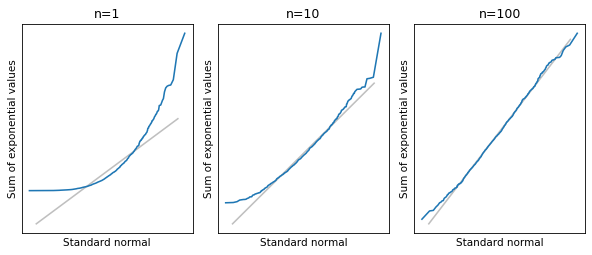

<IPython.core.display.Javascript object>

In [175]:
normal_plot_samples(sample_map_expo, ylabel="Sum of exponential values")

When `n=1`, the distribution of the sum is exponential, so the normal probability plot is not a straight line.
But with `n=10` the distribution of the sum is approximately normal, and with `n=100` it is almost indistinguishable from normal.

For distributions that are less skewed than an exponential, the distribution of the sum converges to normal more quickly -- that is, for smaller values of `n`.
For distributions that are more skewed, it takes longer.
As an example, let's look at sums of values from a lognormal distribution.

In [176]:
mu, sigma = 1.0, 1.0
sample_map_lognormal = {}
for n in [1, 10, 100]:
    sample_map_lognormal[n] = [
        np.sum(np.random.lognormal(mu, sigma, n)) for _ in range(1001)
    ]

<IPython.core.display.Javascript object>

Here are the normal probability plots for the same range of sample sizes.

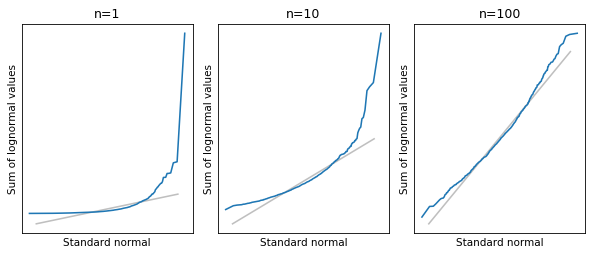

<IPython.core.display.Javascript object>

In [177]:
normal_plot_samples(sample_map_lognormal, ylabel="Sum of lognormal values")

When `n=1`, a normal model does not fit this lognormal distribution, and it is not much better with `n=10`.
Even with `n=100`, the tails of the distribution clearly deviate from the model.

The mean and variance of the lognormal distribution are finite, so the distribution of the sum converges to normal eventually.
But for some highly skewed distributions, it might not converge at any practical sample size.
And in some cases, it doesn't happen at all.

## The Limits of the Central Limit Theorem

Pareto distributions are even more skewed than lognormal.
Depending on the parameters, some Pareto distributions do not have finite mean and variance -- in those cases, the Central Limit Theorem does not apply.

To demonstrate, we'll generate values from a Pareto distribution with `alpha=1`, which has infinite mean and variance.

In [178]:
alpha = 1.0
sample_map = {}
for n in [1, 10, 100]:
    sample_map[n] = [np.sum(np.random.pareto(alpha, n)) for _ in range(1001)]

<IPython.core.display.Javascript object>

Here's what the normal probability plots look like for a range of sample sizes.

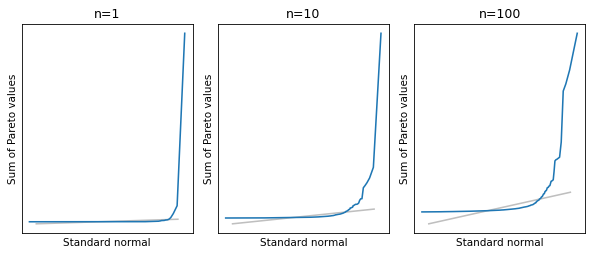

<IPython.core.display.Javascript object>

In [179]:
normal_plot_samples(sample_map, ylabel="Sum of Pareto values")

Even with `n=100`, the distribution of the sum is nothing like a normal distribution.

I also mentioned that the CLT does not apply if the values are correlated.
To test that, we'll use the following function, which generates values from a normal distribution where the serial correlation -- that is, the correlation between successive elements in the sample -- is the given value, `rho`.

In [180]:
def generate_normal_correlated(rho, n):
    """Generates an array of correlated values from a standard normal dist."""
    xs = np.empty(n)
    xs[0] = np.random.normal(0, 1)

    sigma = np.sqrt(1 - rho**2)
    for i in range(1, n):
        xs[i] = rho * xs[i - 1] + np.random.normal(0, sigma)

    return xs

<IPython.core.display.Javascript object>

Given a correlated sequence from a normal distribution, the following function generates a correlated sequence from an exponential distribution.

In [181]:
from scipy.stats import expon


def generate_expo_correlated(rho, n):
    """Generates a sequence of correlated values from an exponential dist."""
    normal = generate_normal_correlated(rho, n)
    uniform = norm.cdf(normal)
    expo = expon.ppf(uniform)
    return expo

<IPython.core.display.Javascript object>

We start with a sequence of correlated normal values and use the normal CDF to transform them to a sequence of values from a uniform distribution between 0 and 1, `uniform`.
Then we use the exponential inverse CDF to transform them to a sequence of exponential values.

Again can make a dictionary that maps from each sample size to a sample of sums.

In [182]:
rho = 0.8
sample_map = {}
for n in [1, 10, 100]:
    sample_map[n] = [np.sum(generate_expo_correlated(rho, n)) for _ in range(1001)]

<IPython.core.display.Javascript object>

Here are the normal probability plots.

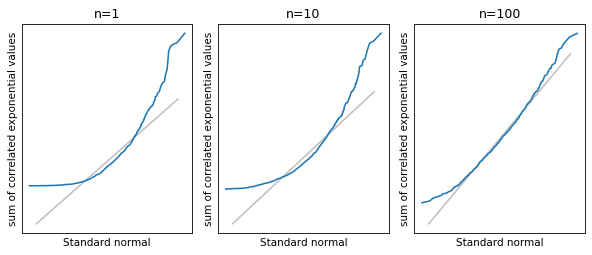

<IPython.core.display.Javascript object>

In [183]:
normal_plot_samples(sample_map, ylabel="sum of correlated exponential values")

With `rho=0.8`, there is a strong correlation between successive elements, and the distribution of the sum converges more slowly.
If there is a strong correlation between distant elements of the sequence, it might not converge at all.

These experiments are meant to show how the Central Limit Theorem works, and what happens when it doesn't.
Now let's see how we can use it.

## Applying the CLT

To see why the Central Limit Theorem is useful, let's get back to the example in Section XXX: testing the apparent difference in mean pregnancy length for first babies and others.
Instructions for downloading the NSFG data are in the notebook for this chapter.

The following cell downloads the data.

In [184]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

We'll use `get_nsfg_groups` to read the data and divide it into first babies and others.

In [185]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

<IPython.core.display.Javascript object>

As we've seen, first babies are born a little later, on average -- the apparent difference is about 0.078 weeks.

In [186]:
delta = firsts["prglngth"].mean() - others["prglngth"].mean()
delta

0.07803726677754952

<IPython.core.display.Javascript object>

Now, to see whether this difference might have happened by chance, we'll assume as a null hypothesis that the mean and variance of pregnancy lengths is actually the same for both groups, so we can estimate is using all live births.


In [193]:
all_lengths = live["prglngth"]
m, s2 = all_lengths.mean(), all_lengths.var()

<IPython.core.display.Javascript object>

The distribution of pregnancy lengths does not follow a normal distribution -- nevertheless, we can use a normal distribution to compute the sampling distribution of the mean.
Here's the sampling distribution for first births.

In [194]:
n1 = len(firsts)
dist_firsts = Normal(m, s2).sum(n1) / n1
n1

4413

<IPython.core.display.Javascript object>

And here's the sampling distribution for others.

In [195]:
n2 = len(others)
dist_others = Normal(m, s2).sum(n2) / n2
n2

4735

<IPython.core.display.Javascript object>

So we can compute the sampling distribution of the difference like this.

In [190]:
dist_diff = dist_firsts - dist_others
dist_diff

Normal(0.0, 0.0031970795988180128)

<IPython.core.display.Javascript object>

The mean is 0, which makes sense because if we draw two samples from the same distribution, we expect the difference in means to be 0, on average.
The variance of the sampling distribution is 0.0032, which indicates how much variation we expect in the differences due to chance.

We can also estimate the sampling distribution by resampling.

In [199]:
sample_firsts = [np.random.choice(all_lengths, n1).mean() for i in range(1001)]
sample_others = [np.random.choice(all_lengths, n2).mean() for i in range(1001)]
sample_diffs = np.subtract(sample_firsts, sample_others)

<IPython.core.display.Javascript object>

Here's the empirical CDF of the resampled differences compared to the normal model.
The vertical dotted lines show the observed difference, positive and negative. 

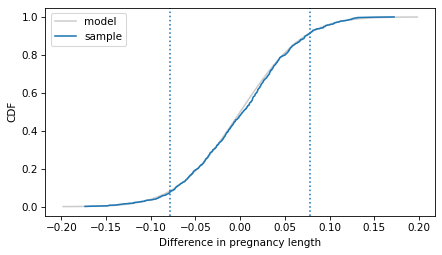

<IPython.core.display.Javascript object>

In [204]:
dist_diff.plot_cdf(**model_options)
Cdf.from_seq(sample_diffs).plot(label="sample")
plt.axvline(delta, ls=":")
plt.axvline(-delta, ls=":")

decorate(xlabel="Difference in pregnancy length", ylabel="CDF")

In this example, the sample sizes are large and the skewness of the measurements is modest, so the sampling distribution is well approximated by a normal distribution.
Therefore, we can use the normal CDF to compute a p-value.
The following method computes the CDF of a normal distribution.

In [65]:
%%add_method_to Normal

def cdf(self, xs):
    sigma = np.sqrt(self.sigma2)
    return norm.cdf(xs, self.mu, sigma)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Here's the probability of a difference as large as `delta` under the null hypothesis, which is the right tail of the sampling distribution.

In [125]:
right = 1 - dist_diff.cdf(delta)
right

0.08377070425543787

<IPython.core.display.Javascript object>

And here's the probability of a difference as small as `-delta`.

In [126]:
left = dist_diff.cdf(-delta)
left

0.08377070425543781

<IPython.core.display.Javascript object>

`left` and `right` are the same because the normal distribution is symmetric.
The sum of the two is the probability of a difference as large as `delta`, positive or negative.

In [127]:
left + right

0.16754140851087568

<IPython.core.display.Javascript object>

The p-value is 0.168, which is consistent with the estimate we computed by resampling in Section XXX.

The way we computed this p-value is similar to an **independent sample $t$ test**.
SciPy provides a function called `ttest_ind` that takes two samples and computes a p-value for the difference in their means.

In [128]:
from scipy.stats import ttest_ind

result = ttest_ind(firsts["prglngth"], others["prglngth"])
result.pvalue

0.16755412639415004

<IPython.core.display.Javascript object>

When the sample sizes are large, the result of the $t$ test is close to what we computed with normal distributions.

The $t$ test is so called because it is based on a Student $t$ distribution rather than a normal distribution.
The $t$ distribution is also useful for testing whether a correlation is statistically significant, as we'll see in the next section.

## Correlation Test

In Section xxx we used a permutation test for the correlation between birth weight and mother's age, and found that it is statistically significant, with p-value less than 0.001.

Now we can do the same thing analytically.
The method is based on this mathematical result: If we generate two samples with size `n` from a normal distributions, compute Pearson's correlation, `r`, and then transform the correlation with this function:

In [230]:
def transform_correlation(r, n):
    return r * np.sqrt((n - 2) / (1 - r**2))

<IPython.core.display.Javascript object>

The transformed correlations follow a Student's $t$ distribution with parameter $n-2$.
To see what that looks like, we'll use the following function to generate uncorrelated samples from a standard normal distribution.

In [231]:
def generate_data(n):
    """Uncorrelated sequences from a standard normal."""
    xs = np.random.normal(0, 1, n)
    ys = np.random.normal(0, 1, n)
    return xs, ys

<IPython.core.display.Javascript object>

And the following function to compute their correlation.

In [232]:
def correlation(data):
    xs, ys = data
    return np.corrcoef(xs, ys)[0, 1]

<IPython.core.display.Javascript object>

The following loop generates many pairs of samples, computes their correlation, and puts the results in a list.

In [238]:
n = 100
rs = [correlation(generate_data(n)) for i in range(1001)]

<IPython.core.display.Javascript object>

Next we'll compute the transformed correlations.

In [239]:
ts = transform_correlation(np.array(rs), n)

<IPython.core.display.Javascript object>

To check whether these `ts` follow a $t$ distribution, we'll use the following function, which makes a `Cdf` object that represents the CDF of a $t$ distribution.

In [241]:
from scipy.stats import t as student_t


def make_student_cdf(df):
    """Computes the CDF of a Student t distributions."""
    ts = np.linspace(-3, 3, 101)
    ps = student_t.cdf(ts, df=df)
    return Cdf(ps, ts)

<IPython.core.display.Javascript object>

The parameter of the $t$ distribution is called `df`, which stands for "degrees of freedom".
The following figure shows the CDF of a $t$ distribution with parameter `n-2` along with the empirical CDF of the transformed correlations.

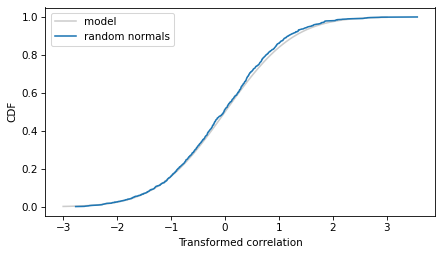

<IPython.core.display.Javascript object>

In [242]:
make_student_cdf(df=n-2).plot(**model_options)
cdf_ts.plot(label="random normals")

decorate(xlabel="Transformed correlation", ylabel="CDF")

This shows that if we draw uncorrelated samples from normal distributions, their transformed correlations follow a $t$ distribution.

If we draw samples from other distributions, their transformed correlations don't follow a $t$ distribution exactly, but they converge to a $t$ distribution as the sample size increases.

Let's see if this applies to the correlation of maternal age and birth weight.
From the `DataFrame` of live births, we'll select the rows with valid data.

In [243]:
valid = live.dropna(subset=["agepreg", "totalwgt_lb"])
n = len(valid)
n

9038

<IPython.core.display.Javascript object>

The actual correlation is about 0.07.

In [244]:
data = valid["agepreg"].values, valid["totalwgt_lb"].values
r_actual = correlation(data)
r_actual

0.0688339703541091

<IPython.core.display.Javascript object>

As we did in Section xxx, we can simulate the null hypothesis by permuting the samples.

In [245]:
def permute(data):
    """Shuffle the x values."""
    xs, ys = data
    new_xs = xs.copy()
    np.random.shuffle(new_xs)
    return new_xs, ys

<IPython.core.display.Javascript object>

If we generate many permutations and compute their correlations, the result is a sample from the distribution of correlations under the null hypothesis.

In [246]:
permuted_corrs = [correlation(permute(data)) for i in range(1001)]

<IPython.core.display.Javascript object>

And we can compute the transformed correlations like this.

In [250]:
ts = transform_correlation(np.array(permuted_corrs), n)

<IPython.core.display.Javascript object>

The following figure shows the empirical CDF of the `ts` along with the CDF of the $t$ distribution with parameter `n-2`.

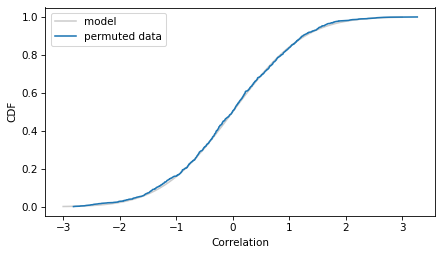

<IPython.core.display.Javascript object>

In [252]:
make_student_cdf(n).plot(**model_options)
Cdf.from_seq(ts).plot(label="permuted data")

decorate(xlabel="Correlation", ylabel="CDF")

The model fits the empirical distribution well, which means we can use it to compute a p-value for the observed correlation.
First we'll transform the observed correlation.

In [262]:
t_actual = transform_correlation(r_actual, n)

<IPython.core.display.Javascript object>

Now we can use the CDF of the $t$ distribution to compute the probability of a value as large as `t_actual` under the null hypothesis.

In [263]:
right = 1 - student_t.cdf(t_actual, df=n - 2)
right

2.861466619208386e-11

<IPython.core.display.Javascript object>

We can also compute the probability of a value as small as `-t_actual`.

In [264]:
left = student_t.cdf(-t_actual, df=n - 2)
left

2.8614735536574016e-11

<IPython.core.display.Javascript object>

The sum of the two is the probability of a correlation as big as `t_actual`, positive or negative.

In [260]:
left + right

5.722940172865787e-11

<IPython.core.display.Javascript object>

SciPy provides a function that does the same calculation and returns the p-value of the observed correlation.

In [256]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(*data)
p_value

5.722947107314431e-11

<IPython.core.display.Javascript object>

Based on the resampling results, we concluded that the p-value was less than 0.001, but we could not say how much less without running a very large number of resamplings.
With analytic methods, we can compute small p-values quickly.

However, in practice it might not matter.
Generally, if a p-value is smaller than 0.001, we can conclude that the observed effect is unlikely to be due to chance.
It is not important to know precisely how unlikely.

## Chi-squared Test

In Section XXX we tested whether a die is crooked, based on this set of observed outcomes.

In [268]:
from empiricaldist import Hist

qs = np.arange(1, 7)
freqs = [8, 9, 19, 5, 8, 11]
observed = Hist(freqs, qs)
observed.index.name = "outcome"
observed

,freqs
outcome,
1,8
2,9
3,19
4,5
5,8
6,11


<IPython.core.display.Javascript object>

First we computed the expected frequency for each outcome.

In [269]:
num_rolls = observed.sum()
outcomes = observed.qs
expected = Hist(num_rolls / 6, outcomes)

<IPython.core.display.Javascript object>

Then we used the following function to compute the chi-squared statistic.

In [270]:
def chi_squared_stat(observed):
    diffs = (observed - expected) ** 2
    return np.sum((observed - expected) ** 2 / expected)

<IPython.core.display.Javascript object>

The chi-squared statistic is widely used for this kind of data because its sampling distribution under the null hypothesis converges to a distribution we can compute efficiently -- not coincidentally, it is called a chi-squared distribution.
To see what it looks like, we'll use the following function, which simulates rolling a fair die.

In [85]:
def simulate_dice(observed):
    n = np.sum(observed)
    rolls = np.random.choice(observed.qs, n, replace=True)
    hist = Hist.from_seq(rolls)
    return hist

<IPython.core.display.Javascript object>

The following loop runs the simulation many times and computes the chi-squared statistic of the outcomes.

In [86]:
simulated_chi_squared = [chi_squared_stat(simulate_dice(observed)) for i in range(1001)]
cdf_simulated = Cdf.from_seq(simulated_chi_squared)

<IPython.core.display.Javascript object>

The following function computes the CDF of a chi-squared distribution with parameter `df`.

In [278]:
from scipy.stats import chi2 as chi2_dist


def chi_squared_cdf(df):
    """Discrete approximation of the chi-squared CDF with df=n-1.

    n: sample size

    returns: Cdf
    """
    xs = np.linspace(0, 21, 101)
    ps = chi2_dist.cdf(xs, df=df)
    return Cdf(ps, xs)

<IPython.core.display.Javascript object>

With `n` possible outcomes, the simulated chi-squared statistics should follow a chi-squared distibution with parameter `n-1`.

In [279]:
n = len(observed)
cdf_model = chi_squared_cdf(df=n - 1)

<IPython.core.display.Javascript object>

Here's the empirical CDF of the simulated chi-squared statistics along with the CDF of the chi-squared distribution.

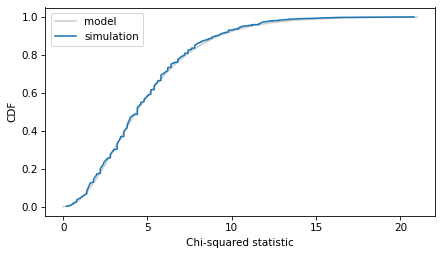

<IPython.core.display.Javascript object>

In [280]:
cdf_model.plot(**model_options)
cdf_simulated.plot(label="simulation")

decorate(xlabel="Chi-squared statistic", ylabel="CDF")

The model fits the simulation results well, so we can use it to compute the probability of a value as large as `observed_chi2` under the null hypothesis.

In [281]:
p_value = 1 - chi2_dist.cdf(observed_chi2, df=n - 1)
p_value

0.04069938850404997

<IPython.core.display.Javascript object>

SciPy provides a function that does the same computation.
To call it, we have to put the expected frequencies in a normalized `Pmf`. 

In [282]:
from empiricaldist import Pmf

expected = Pmf(num_rolls / 6, outcomes)

<IPython.core.display.Javascript object>

Now we can call it like this.

In [283]:
from scipy.stats import chisquare

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

11.6

<IPython.core.display.Javascript object>

The result is the same as the p-value we computed.

In [284]:
p_value

0.040699388504049985

<IPython.core.display.Javascript object>

The advantage of the chi-squared statistic its distribution under the null hypothesis can be computed efficiently.
But it might not be the statistic that best quantifies the difference between the observed and expected outcomes.

## Discussion

This book focuses on computational methods like resampling and permutation.
These methods have several advantages over analysis:

-   They are easier to explain and understand. For example, one of the most difficult topics in an introductory statistics class is hypothesis testing. Many students don't really understand what p-values are. I think the approach we took in Chapter xxx -- simulating the null hypothesis and computing test statistics -- makes the fundamental idea clearer.

-   They are robust and versatile. Analytic methods are often based on assumptions that might not hold in practice. Computational methods require fewer assumptions, and can be adapted and extended more easily.

-   They are debuggable. Analytic methods are often like a black box: you plug in numbers and they spit out results. But it's easy to make subtle errors, hard to be confident that the results are right, and hard to find the problem if they are not. Computational methods lend themselves to incremental development and testing, which fosters confidence in the results.

But there is one drawback: computational methods can be slow.
Taking into account these pros and cons, I recommend the following process:

1.  Use computational methods during exploration. If you find a satisfactory answer and the run time is acceptable, you can stop.

2.  If run time is not acceptable, look for opportunities to optimize. Using analytic methods is one of several methods of optimization.

3.  If replacing a computational method with an analytic method is appropriate, use the computational method as a basis of comparison, providing mutual validation between the computational and analytic results.

For many practical problems, the run time of computational methods is not a problem, and we don't have to go past the first step.

## Exercises

**Exercise:**    In Section 5.4, we saw that the distribution of adult weights is approximately lognormal.
One possible explanation is that the weight a person gains each year is proportional to their current weight.
In that case, adult weight is the product of a large number of multiplicative factors:

w = w0 f1 f2 ... fn  

where w is adult weight, w0 is birth weight, and fi is the weight gain factor for year i.

The log of a product is the sum of the logs of the factors:

logw = logw0 + logf1 + logf2 + ... + logfn 

So by the Central Limit Theorem, the distribution of logw is approximately normal for large n, which implies that the distribution of w is lognormal.

To model this phenomenon, choose a distribution for f that seems reasonable, then generate a sample of adult weights by choosing a random value from the distribution of birth weights, choosing a sequence of factors from the distribution of f, and computing the product.
What value of n is needed to converge to a lognormal distribution?

In [95]:
def generate_adult_weight(birth_weights, n):
    """Generate a random adult weight by simulating annual gain.

    birth_weights: sequence of birth weights in lbs
    n: number of years to simulate

    returns: adult weight in lbs
    """
    bw = np.random.choice(birth_weights)
    factors = np.random.normal(1.09, 0.03, n)
    aw = bw * np.prod(factors)
    return aw

<IPython.core.display.Javascript object>

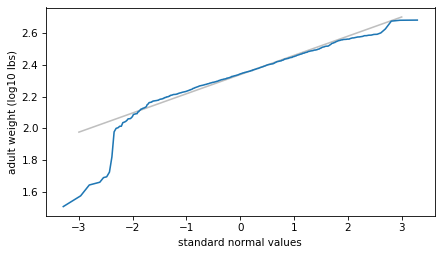

<IPython.core.display.Javascript object>

In [96]:
birth_weights = live.totalwgt_lb.dropna().values
aws = [generate_adult_weight(birth_weights, 40) for _ in range(1000)]
log_aws = np.log10(aws)
normal_probability_plot(log_aws)
decorate(
    xlabel="standard normal values",
    ylabel="adult weight (log10 lbs)",
)

**Exercise:** In Section 14.6 we used the Central Limit Theorem to find the sampling distribution of the difference in means, δ, under the null hypothesis that both samples are drawn from the same population.

We can also use this distribution to find the standard error of the estimate and confidence intervals, but that would only be approximately correct.
To be more precise, we should compute the sampling distribution of δ under the alternate hypothesis that the samples are drawn from different populations.

Compute this distribution and use it to calculate the standard error and a 90% confidence interval for the difference in means.

In [97]:
# Solution

delta = firsts["prglngth"].mean() - others["prglngth"].mean()
print(delta)

0.07803726677754952


<IPython.core.display.Javascript object>

In [98]:
# Solution

dist1 = sampling_dist_mean(live.prglngth, len(firsts))
dist2 = sampling_dist_mean(live.prglngth, len(others))
dist_diff_null = dist1 - dist2
print("null hypothesis", dist_diff_null)
print(dist_diff_null.cdf(-delta), 1 - dist_diff_null.cdf(delta))

null hypothesis Normal(0.0, 0.0031970795988180128)
0.08377070425543781 0.08377070425543787


<IPython.core.display.Javascript object>

In [99]:
# Solution

dist1 = sampling_dist_mean(firsts.prglngth, len(firsts))
dist2 = sampling_dist_mean(others.prglngth, len(others))
dist_diff_alt = dist1 - dist2
print("estimated params", dist_diff_alt)
print(dist_diff_alt.ppf([0.05, 0.95]))

estimated params Normal(0.07803726677755662, 0.003211435677916403)
[-0.01517582  0.17125035]


<IPython.core.display.Javascript object>

In [100]:
dist_diff_null

Normal(0.0, 0.0031970795988180128)

<IPython.core.display.Javascript object>

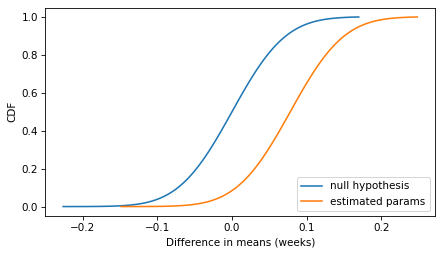

<IPython.core.display.Javascript object>

In [101]:
# Solution

dist_diff_null.plot_cdf(label="null hypothesis")
dist_diff_alt.plot_cdf(label="estimated params")
decorate(xlabel="Difference in means (weeks)", ylabel="CDF", loc="lower right")

**Exercise:** [In a 2014 paper](http://ieeexplore.ieee.org/document/7044435/), Stein et al. investigate the effects of an intervention intended to mitigate gender-stereotypical task allocation within student engineering teams.

Before and after the intervention, students responded to a survey that asked them to rate their contribution to each aspect of class projects on a 7-point scale.

Before the intervention, male students reported higher scores for the programming aspect of the project than female students; on average men reported a score of 3.57 with standard error 0.28. Women reported 1.91, on average, with standard error 0.32.

Compute the sampling distribution of the gender gap (the difference in means), and test whether it is statistically significant.
Because you are given standard errors for the estimated means, you don’t need to know the sample size to figure out the sampling distributions.

After the intervention, the gender gap was smaller: the average score for men was 3.44 (SE 0.16); the average score for women was 3.18 (SE 0.16).
Again, compute the sampling distribution of the gender gap and test it.

Finally, estimate the change in gender gap; what is the sampling distribution of this change, and is it statistically significant?

"Evidence for the persistent effects of an intervention to mitigate gender-stereotypical task allocation within student engineering teams," Proceedings of the IEEE Frontiers in Education Conference, 2014.

In [102]:
# Solution

male_before = Normal(3.57, 0.28**2)
male_after = Normal(3.44, 0.16**2)
female_before = Normal(1.91, 0.32**2)
female_after = Normal(3.18, 0.16**2)

<IPython.core.display.Javascript object>

In [103]:
# Solution


def summarize(dist):
    print("mean, p-value", dist.mu, 1 - dist.cdf(0))
    print("CI", dist.ppf([0.05, 0.95]))
    print("stderr", np.sqrt(dist.sigma2))

<IPython.core.display.Javascript object>

In [104]:
# Solution

diff_before = female_before - male_before
summarize(diff_before)

mean, p-value -1.66 4.7309532320793934e-05
CI [-2.35940136 -0.96059864]
stderr 0.425205832509386


<IPython.core.display.Javascript object>

In [105]:
# Solution

diff_after = female_after - male_after
summarize(diff_after)

mean, p-value -0.2599999999999998 0.1252679872068192
CI [-0.63218789  0.11218789]
stderr 0.2262741699796952


<IPython.core.display.Javascript object>

In [106]:
# Solution

diff = diff_after - diff_before
summarize(diff)

mean, p-value 1.4000000000000001 0.998173051631023
CI [0.60773358 2.19226642]
stderr 0.48166378315169184


<IPython.core.display.Javascript object>

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)